In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import eeg

## Dataset description: Error-related potentials (ErrPs) during continuous feedback

*(taken from the supplementary material of [1]).*

In total the dataset consists of 10 sessions (one session for each of the 10 subjects). The data for each
session is saved in a separate .mat file which can be read using MATLAB software. The EEG data for
each session has already been cut into trials with the corresponding labels. Each .mat file contains the
following variables:

- eeg signal - this variable has dimensions samples × channels. It contains the complete EEG data of the one session. The first 28 channels are the EEG channels, while channels 29, 30, 31 are EOG channels.
- info - this struct contains information about the subject, the samplingrate and the channel names (according to 10-20 system).
- marker - this struct contains information about the errors and the thumbstick position. This struct will be described below in more detail. The struct marker contains the following variables:
    - execution error - this variable has dimensions samples × 1 and is 1 if an execution error is happening at that time point (0 otherwise).
    - execution error angle - if an execution error is happening, this variable describes the angle modification of the error (in °) or is -1 if no execution error is happening.
    - outcome error - this variable has dimensions samples × 1 and is 1 if an outcome error (collision) is happening at that time point (0 otherwise). Since the game is stopped after an outcome error (with delay of 1 s), this variable has a value of 1 until the game resumes. thumbstick angle - this variable has dimensions samples × 1 and shows the position of the thumbstick. The data is saved in 6° resolution and a value of -1 means that the thumbstick is in a neutral position.

### References 

[1] Spüler M, Niethammer C (2015) Error-related potentials during continuous feedback: using EEG to
detect errors of different type and severity. Frontiers in Human Neuroscience 9:155. doi: 10.3389/fnhum.2015.00155.

In [9]:
from scipy.io import loadmat
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [338]:
data = loadmat("/sync/datasets/S04.mat")

In [339]:
remap = np.array([chnames.index(ch) for ch in montage.ch_names] + [28,29,30])
raw_signal = data['eeg_signal'].T.copy()
raw_signal[:,:] = raw_signal[remap,:]
raw_signal.shape

(31, 1836832)

Creating RawArray with float64 data, n_channels=31, n_times=1836832
    Range : 0 ... 1836831 =      0.000 ...  3587.561 secs
Ready.
Effective window size : 4.000 (s)


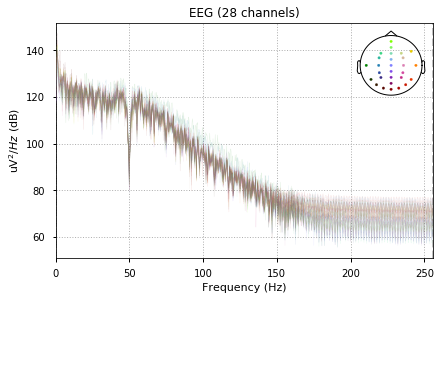

Effective window size : 8.000 (s)


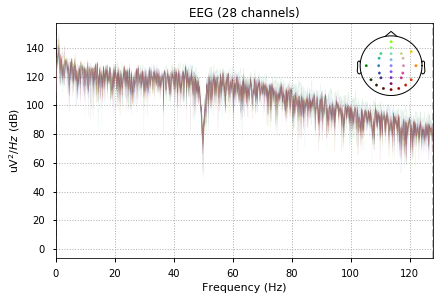

Effective window size : 8.000 (s)


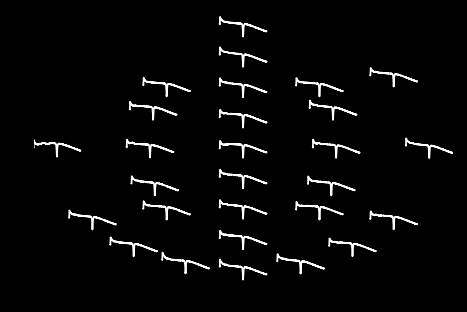

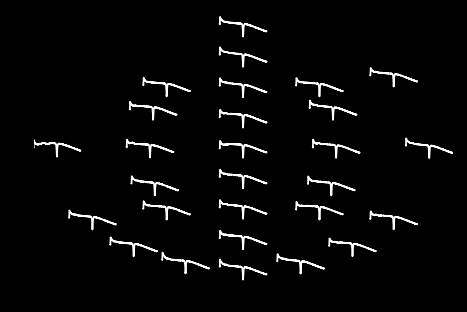

In [341]:
import mne

montage = mne.channels.read_montage('easycap-M1', ch_names=chnames)
info = mne.create_info(chnames, 512, ch_types=['eeg']*28+['eog']*3, montage=montage)
raw = mne.io.RawArray(raw_signal, info)

fmin, fmax = 2, 256  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2

raw.plot_psd(area_mode='range', tmax=10.0, average=False)
plt.show()

raw.resample(256, npad="auto")  # set sampling frequency to 100Hz
raw.plot_psd(area_mode='range', tmax=10.0, average=False)
plt.show()

raw.plot_psd_topo()

#raw.set_eeg_reference('average')
#raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)
#plt.show()

In [342]:
signal = raw.to_data_frame().as_matrix(chnames) / 1e6

signal.max(), len(signal)

Converting time column to int64...


(358.46675094055297, 918416)

In [346]:
from sklearn.decomposition import FastICA

ica = FastICA(whiten=True)
ica.fit(signal)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [347]:
ICs = ica.transform(signal)

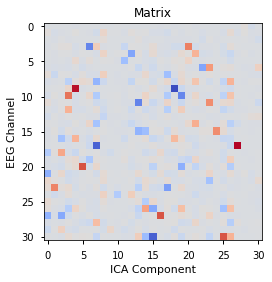

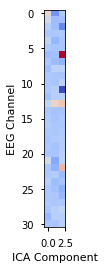

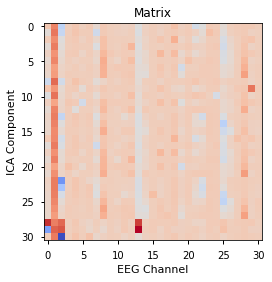

In [384]:
plt.title("Matrix")
# (n_components, n_features)
plt.imshow(ica.components_, cmap='coolwarm')
plt.ylabel('EEG Channel')
plt.xlabel('ICA Component')
plt.show()

plt.imshow(ica.components_[:,-3:], cmap='coolwarm')
plt.ylabel('EEG Channel')
plt.xlabel('ICA Component')
plt.show()

plt.title("Matrix")
# (n_components, n_features)
plt.imshow(ica.mixing_, cmap='coolwarm')
plt.xlabel('EEG Channel')
plt.ylabel('ICA Component')
plt.show()

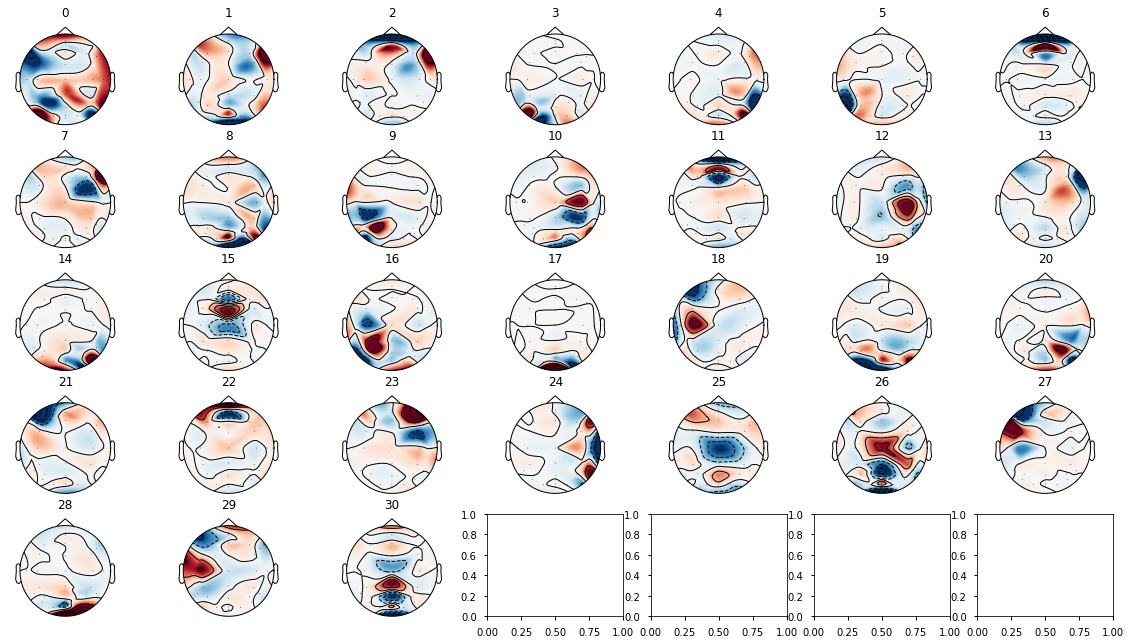

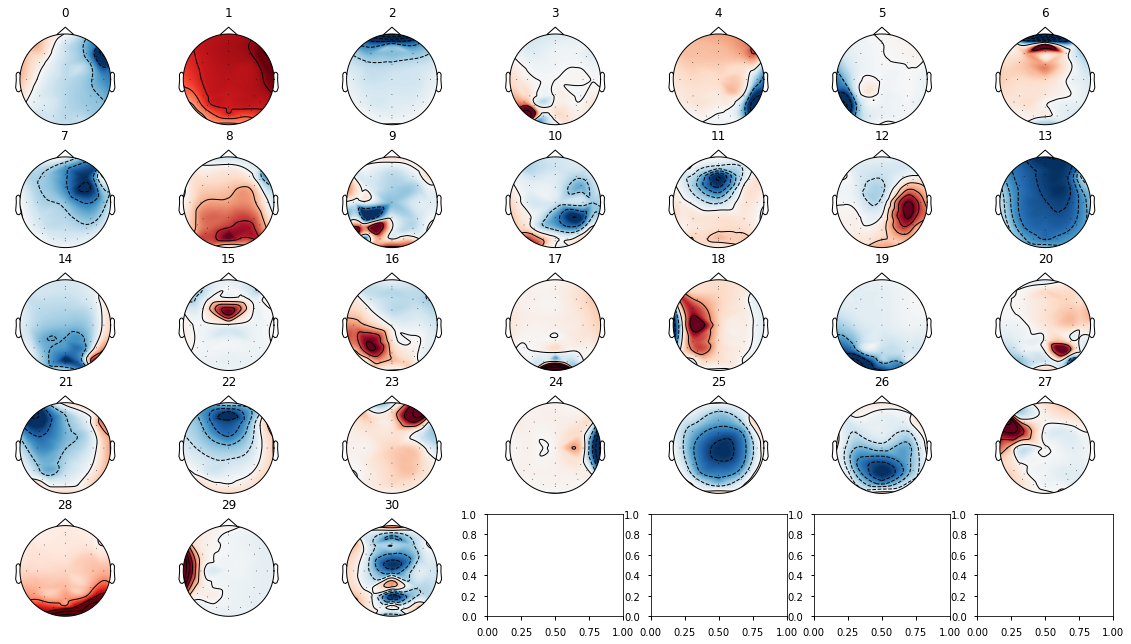

In [371]:
fig, axes = plt.subplots(5,7,figsize=(20,10))
for i, (ax, ch) in enumerate(zip(axes.flatten()[:31], montage.ch_names+("eog", "eog", "eog"))):
    mne.viz.plot_topomap(ica.components_[i,:28], montage.pos[:,:2], axes = ax, show=False)
    ax.set_title(str(i))
plt.show()

fig, axes = plt.subplots(5,7,figsize=(20,10))
for i, (ax, ch) in enumerate(zip(axes.flatten()[:31], montage.ch_names+("eog", "eog", "eog"))):
    mne.viz.plot_topomap(ica.mixing_[:28,i], montage.pos[:,:2], axes = ax, show=False)
    ax.set_title(str(i))
plt.show()

In [379]:
ICs.shape

(918416, 31)

In [380]:
keep = [25, 26, 1, 15, 16, 18]

ICs_keep = np.zeros_like(ICs)
ICs_keep[:,keep] = ICs[:,keep]

signal_remixed = ica.inverse_transform(ICs_keep)

In [381]:
signal_remixed.shape

(918416, 31)

In [284]:
import sklearn.linear_model

def detrend(signal):
    model = sklearn.linear_model.LinearRegression(normalize=False, n_jobs=4)

    x = []
    for ii in range(0,len(signal),5000):
        ii = slice(ii, ii+5000)
        
        eog        = signal[ii,-3:].copy()
        eog_smooth = signal[ii,-3:].copy()

        for i in range(eog.shape[1]):
            eog_smooth[:,i] = np.convolve(eog[:,i].copy(), np.ones(10)/10, mode='same')

        eog = np.concatenate([eog, eog_smooth], axis=-1)    

        model.fit(eog, signal[ii,:-3])

        print(model.score(eog, signal[ii,:-3]))
        
        x.append(signal[ii,:-3] - model.predict(eog))
        
    return np.concatenate(x)

signal_detrend = detrend(signal.copy())
len(signal_detrend)

0.269749803182
0.306949536335
0.340227516856
0.305209253201
0.361998619306
0.315183178092
0.326831969616
0.236355317369
0.347905902877
0.371968417823
0.34953638704
0.346868108163
0.34402674564
0.27460150343
0.305111302526
0.340105163705
0.294687946606
0.368694326754
0.35835787232
0.391926927813
0.312465243195
0.336661762576
0.339056816013
0.316564985803
0.345708581893
0.277322695042
0.263682738157
0.372878550619
0.36793410745
0.333598618662
0.248452012773
0.354758029035
0.356621047184
0.363894304133
0.314701482347
0.322823417565
0.337788533526
0.30975057677
0.357123904169
0.292630117354
0.443977143486
0.291317220823
0.361155804159
0.290030687075
0.273718666047
0.403382812781
0.403775941167
0.380189005541
0.329205004539
0.387393111766
0.328012564808
0.373416115382
0.340828580506
0.360124332155
0.407190513741
0.325223994364
0.30426677949
0.336946531078
0.361070769893
0.372065917044
0.367196623057
0.317541441866
0.357862063164
0.327603104188
0.323033870734
0.341301814166
0.369582366723
0.

918416

In [214]:
signal_detrend = detrend(signal)

0.201213853725


In [271]:
signal_detrend.shape, signal.shape

((918416, 28), (918416, 31))

### Extract Event Epochs

#### Extract indices for all event types

In [272]:
idc_exec = eeg.extract_idc(data['marker']['execution_error'][0,0][:,0])
idc_outc = eeg.extract_idc(data['marker']['outcome_error'][0,0][:,0])
idc_neg  = eeg.select_negative_spaced(data['marker']['execution_error'][0,0][:,0] +\
                                      data['marker']['outcome_error'][0,0][:,0], idc_exec)

522 isolated events detected
77 isolated events detected
240 isolated events detected


#### Epoch the dataset

In [382]:
def epoch(signal, nb_ch, idc_exec, idc_outc, idc_neg):
    X_exec = eeg.extract_epochs(signal, idc_exec, nb_ch, 256)
    X_outc = eeg.extract_epochs(signal, idc_outc, nb_ch, 256)
    X_neg  = eeg.extract_epochs(signal, idc_neg, nb_ch, 256)

    X, y   = eeg.merge_datasets([X_exec, X_outc, X_neg], [1,2,0])
    
    return X, y

X, y = epoch(signal_remixed, 31, idc_exec//2, idc_outc//2, idc_neg//2)

In [377]:
X.shape

(839, 384, 31)

### Data Visualization

In [308]:
X_avg = X[...,:28].mean(axis=-1,keepdims=True)
X_ref = X.copy()
X_ref[...,:28] = X[...,:28] - X_avg

In [309]:
def lin_detrend(X, y):
    model = sklearn.linear_model.LinearRegression(n_jobs=4)
    a,b,c = X.shape
    model.fit(X.reshape(a*b,-1),y.reshape(a*b,-1))
    
    return y - model.predict(X.reshape(a*b,-1)).reshape(a,b,-1)
    
for i in [0,1,2]:
    X_ref[y==i] = lin_detrend(X_ref[y==i,:,-3:], X[y==i])

In [153]:
name2id = {name:i for i,name in enumerate(chnames)}

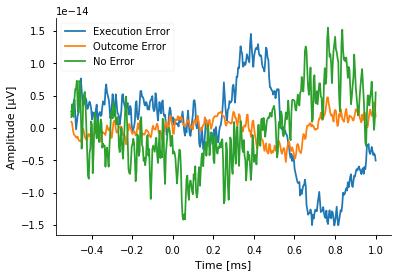

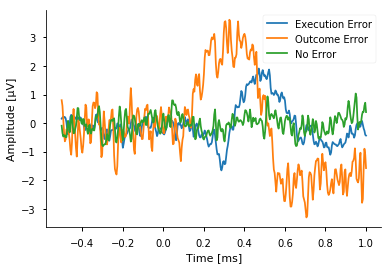

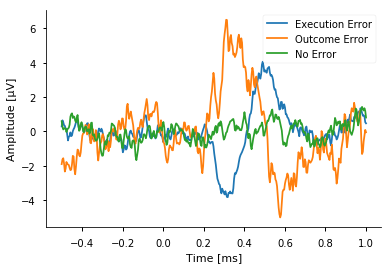

In [383]:
sns.set_context('notebook')

def plot_event(X, ch="FCZ"):

    tt = np.linspace(-.5,1,X.shape[1])

    plt.plot(tt, X[y==1,...,name2id[ch]].mean(axis=(0,)), label='Execution Error')
    plt.plot(tt, X[y==2,...,name2id[ch]].mean(axis=(0,)), label='Outcome Error')
    plt.plot(tt, X[y==0,...,name2id[ch]].mean(axis=(0,)),  label='No Error')
    
    #plt.ylim([-2,2])
    
    plt.ylabel("Amplitude [µV]")
    plt.xlabel("Time [ms]")

    plt.legend()
    sns.despine()

plot_event(X_ref, 'EOG1')
plt.show()

plot_event(X)
plt.show()
plot_event(X_ref)
plt.show()

In [54]:
def plot_uncertainty(t, data, ax=None, c=None):
    
    if ax is None: ax = plt.gca()
    
    mu_train  = data.mean(axis=0)
    std_train = data.std(axis=0)

    ax.plot(t, mu_train)
    ax.fill_between(t, mu_train - .5 * std_train, mu_train + .5 * std_train, alpha=.5)

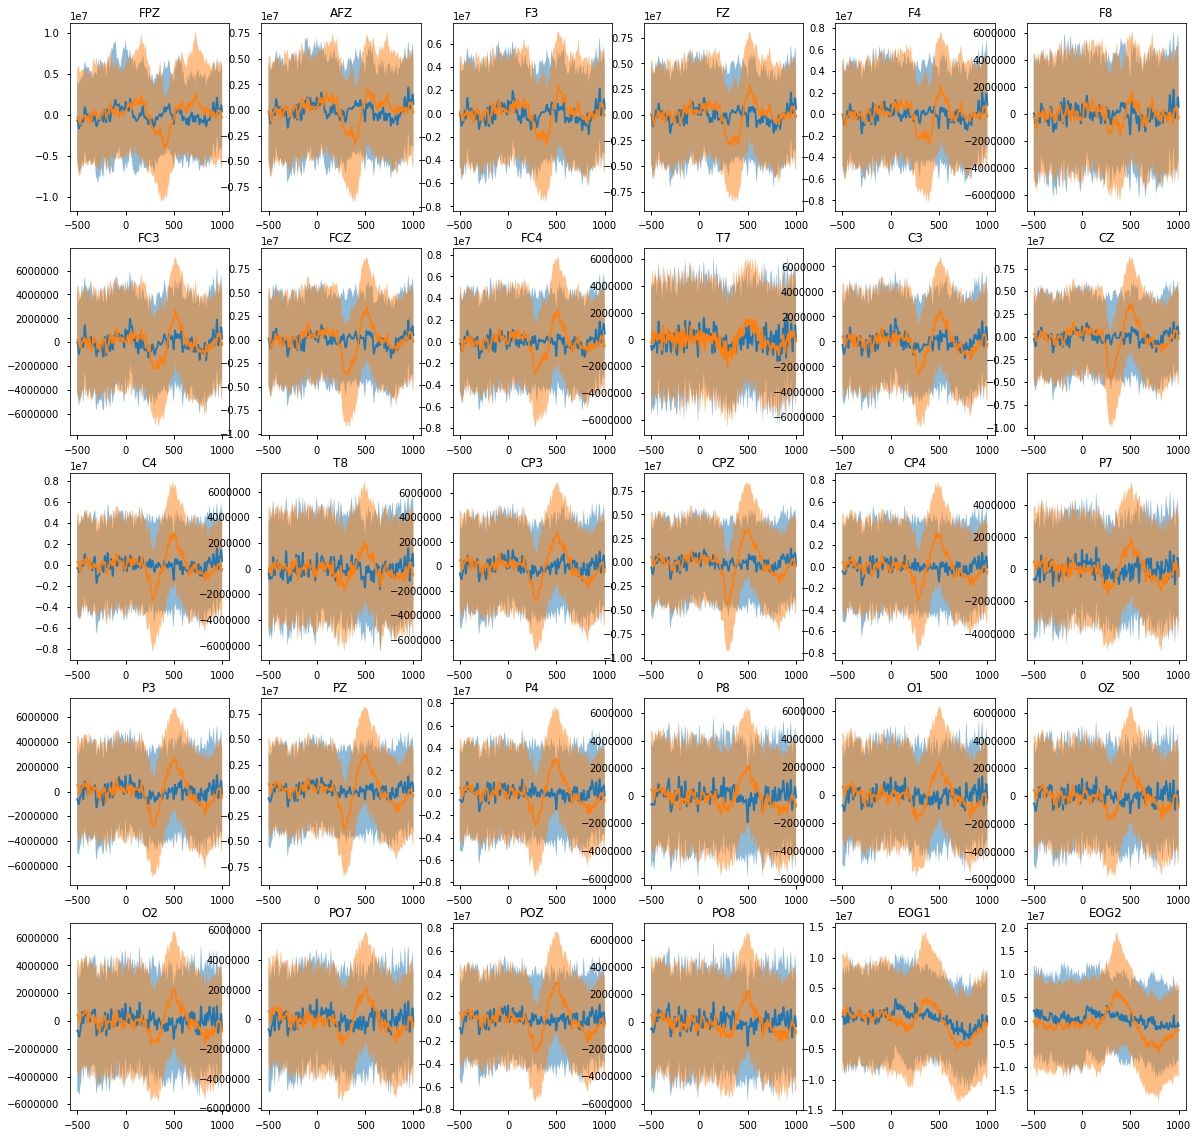

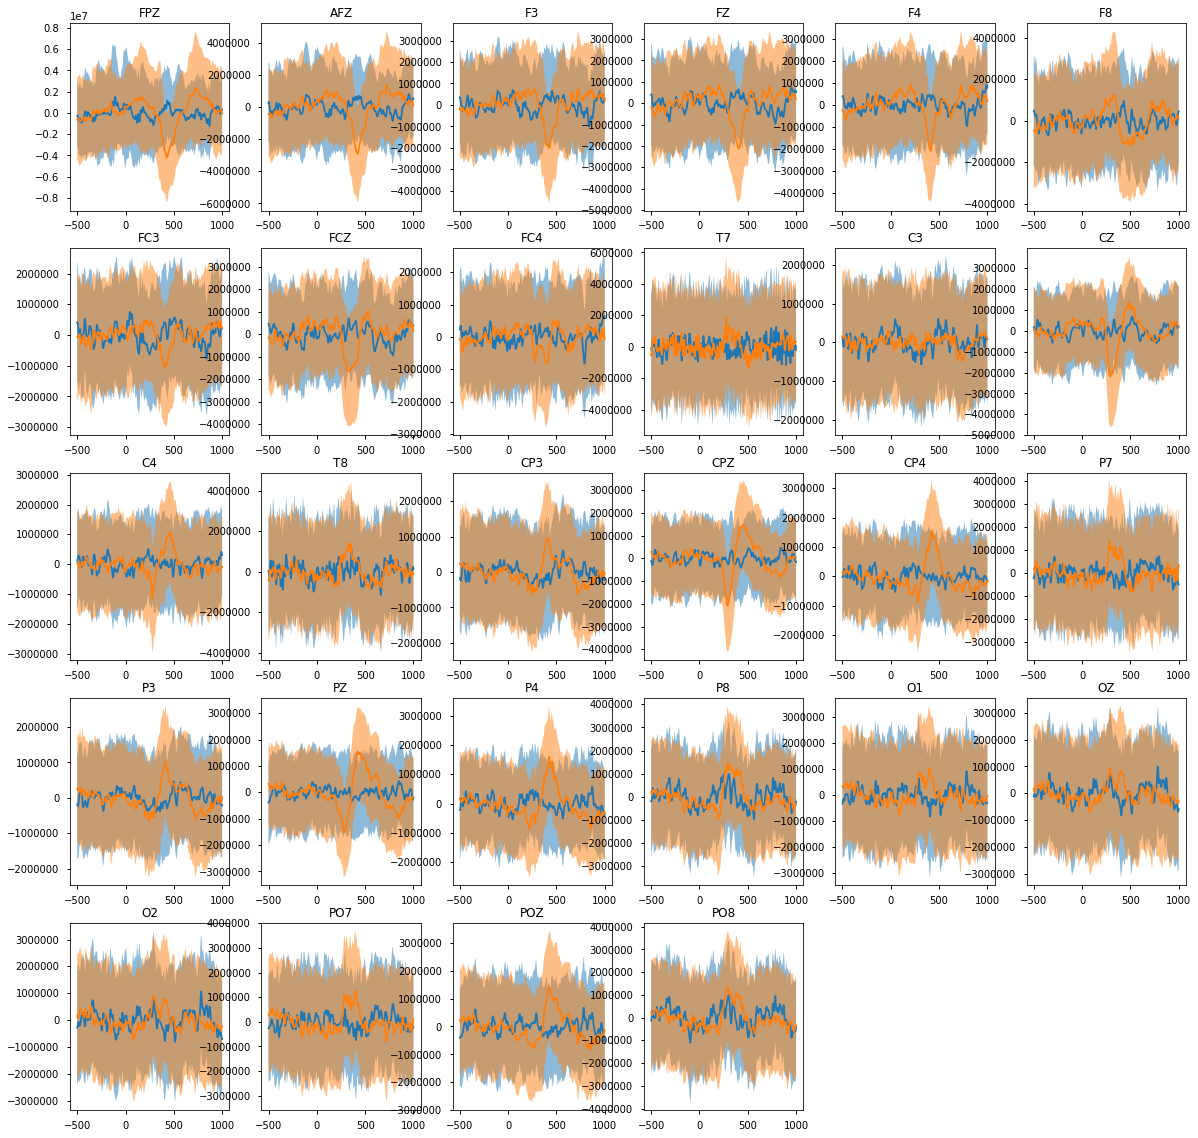

In [94]:
tt = np.linspace(-500,1000,(X.shape[1]))

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plot_uncertainty(tt, X[y==0,...,i], c='blue')
    plot_uncertainty(tt, X[y==1,...,i], c='orange')
    #plt.ylim([-10,10])
    plt.title(chnames[i])
plt.show()

plt.figure(figsize=(20,20))
for i in range(28):
    plt.subplot(5,6,i+1)
    plot_uncertainty(tt, X_ref[y==0,...,i], c='blue')
    plot_uncertainty(tt, X_ref[y==1,...,i], c='orange')
    #plt.ylim([-10,10])
    plt.title(chnames[i])
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, whiten=True)



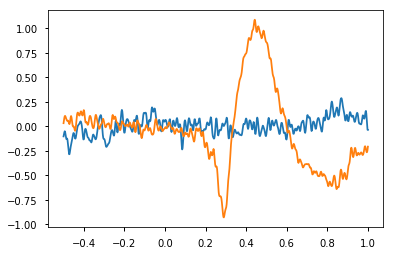

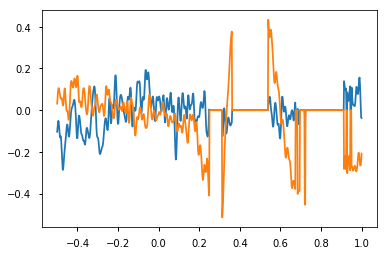

In [61]:
import scipy

plt.plot(tt, X[y==0,:,-4:].mean(axis=(0,2)))
plt.plot(tt, X[y==1,:,-4:].mean(axis=(0,2)))
plt.show()

_,pd = scipy.stats.ttest_ind(X[y==0,:,-4:].mean(axis=-1),X[y==1,:,-4:].mean(axis=-1),axis=0)
mask = (pd < 0.0001)
i = np.where(mask)

X_0 = X[y==0,:,-4:]
X_0[:,i] = 0
X_1 = X[y==1,:,-4:]
X_1[:,i] = 0

plt.plot(tt, X_0.mean(axis=(0,2)))
plt.plot(tt, X_1.mean(axis=(0,2)))
plt.show()

In [ ]:
# check filter design

if False:
    X_filtered = scipy.signal.lfilter(b, a, X['eeg_signal'], axis=0)
    X_filtered = scipy.signal.lfilter(b1, a1, X_filtered, axis=0)

    F_ = scipy.fftpack.fft(X_filtered[10000:50000], axis=0)
    F = scipy.fftpack.fft(X['eeg_signal'][10000:50000], axis=0)

    ff = np.linspace(0,256,len(F_)//2)

    plt.subplot(1,2,1)
    plt.plot(ff, abs(F)[:len(F)//2,0])
    plt.subplot(1,2,2)
    plt.plot(ff, abs(F_)[:len(F_)//2,0])

    plt.title("Power Spectrum")
    plt.show()